In [360]:
# All imports                                                                                     Purpose
import numpy as np #------------------------------------------------------------------------------Numerical computations
import pandas as pd #-----------------------------------------------------------------------------Data structures
import matplotlib.pyplot as plt #-----------------------------------------------------------------Statistic visualizations
import seaborn as sns #---------------------------------------------------------------------------"
import statsmodels.api as sm #--------------------------------------------------------------------Regression modeling
import networkx as nx
import dowhy
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet #---------------------------"
from sklearn.cluster import KMeans #--------------------------------------------------------------Clustering modeling
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor #-------------------------------------------------Decision Tree model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor #---------------------------------------------"
from xgboost import XGBClassifier #---------------------------------------------------------------"
from scipy import stats #-------------------------------------------------------------------------Probability and stat tests
from sklearn.pipeline import Pipeline #-----------------------------------------------------------Pipeline preprocessing
from sklearn.compose import ColumnTransformer #---------------------------------------------------"
from sklearn.impute import SimpleImputer #--------------------------------------------------------"
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures #-------------------Data scalers
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV#---------------------------Model training & validation
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score# Model evaluation
from sklearn.datasets import load_iris #----------------------------------------------------------Sample dataset
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [361]:
df = pd.read_csv('data/anon_cust_data.csv')
print(df.head(10))


   Unnamed: 0  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0           0  Female              0     Yes         No       1           No   
1           1    Male              0      No         No      34          Yes   
2           2    Male              0      No         No       2          Yes   
3           3    Male              0      No         No      45           No   
4           4  Female              0      No         No       2          Yes   
5           5  Female              0      No         No       8          Yes   
6           6    Male              0      No        Yes      22          Yes   
7           7  Female              0      No         No      10           No   
8           8  Female              0     Yes         No      28          Yes   
9           9    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL        

In [362]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7043 non-null   int64  
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [363]:
print(df.describe())

        Unnamed: 0  SeniorCitizen       tenure  MonthlyCharges
count  7043.000000    7043.000000  7043.000000     7043.000000
mean   3521.000000       0.162147    32.371149       64.761692
std    2033.283305       0.368612    24.559481       30.090047
min       0.000000       0.000000     0.000000       18.250000
25%    1760.500000       0.000000     9.000000       35.500000
50%    3521.000000       0.000000    29.000000       70.350000
75%    5281.500000       0.000000    55.000000       89.850000
max    7042.000000       1.000000    72.000000      118.750000


In [364]:
print(df.isnull().sum())

Unnamed: 0          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [365]:
object_columns = df.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)

Object columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'],
      dtype='object')


In [366]:
numeric_columns = df.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_columns)

Numeric columns: Index(['Unnamed: 0', 'SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')


In [367]:

# Clean TotalCharges (string → float, introduces NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Convert Churn to numeric
df["Churn"] = df["Churn"].replace({"No": 0, "Yes": 1})

# Drop index-like column
df = df.drop(columns=["Unnamed: 0"])

# ============================================================
# 3. Train/Test Split
# ============================================================
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ============================================================
# 4. Preprocessing Pipelines
# ============================================================

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
    
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# ============================================================
# 5. Models & Parameter Grids
# ============================================================

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "LogisticRegression": {
        "model__C": [0.1, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [150, 250],
        "model__max_depth": [10, 20, None]
    },
    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [3, 6]
    },
    "SVM": {
        "model__C": [0.5, 1, 2],
        "model__kernel": ["linear", "rbf"]
    },
    "KNN": {
        "model__n_neighbors": [5, 10, 15]
    }
}

results = {}

# ============================================================
# 6. Train + Evaluate Models
# ============================================================

for name, model in models.items():
    print(f"\n============================")
    print(f" Training: {name}")
    print(f"============================")

    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Best Params:", grid.best_params_)
    print("Accuracy:", acc)
    print("ROC AUC:", auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    results[name] = {
        "accuracy": acc,
        "auc": auc,
        "params": grid.best_params_,
        "model": best_model
    }

    # ----------------------------------------------------
    # Feature Importance (if supported)
    # ----------------------------------------------------
    if hasattr(best_model.named_steps["model"], "feature_importances_"):
        print("\nTop Feature Importances:")

        # Get feature names
        ohe = best_model.named_steps["preprocess"].transformers_[1][1].named_steps["encoder"]
        cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
        features = numeric_cols + cat_features

        fi = best_model.named_steps["model"].feature_importances_
        top = pd.DataFrame({"Feature": features, "Importance": fi}).sort_values(
            "Importance", ascending=False
        )

        print(top.head(10))

    if hasattr(best_model.named_steps["model"], "coef_"):
        print("\nLogistic Regression Coefficients:")
        
        ohe = best_model.named_steps["preprocess"].transformers_[1][1].named_steps["encoder"]
        cat_features = ohe.get_feature_names_out(categorical_cols)
        features = numeric_cols + list(cat_features)

        coefs = best_model.named_steps["model"].coef_[0]
        coef_df = pd.DataFrame({"Feature": features, "Coefficient": coefs}).sort_values(
            "Coefficient", ascending=False
        )

        print(coef_df.head(10))

# ============================================================
# 7. Summary Table
# ============================================================

summary = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [round(results[m]["accuracy"], 4) for m in results],
    "ROC AUC": [round(results[m]["auc"], 4) for m in results],
    "Best Params": [results[m]["params"] for m in results]
})

print("\n========================")
print("Summary of All Models")
print("========================")
summary



 Training: LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'model__C': 10}
Accuracy: 0.8026969481902059
ROC AUC: 0.8422563228189827
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409


Logistic Regression Coefficients:
                           Feature  Coefficient
3                     TotalCharges     1.949507
36         Contract_Month-to-month     0.649843
16     InternetService_Fiber optic     0.446955
43  PaymentMethod_Electronic check     0.242727
18               OnlineSecurity_No     0.212381
27                  TechSupport_No     0.187323
0                    SeniorCitizen     0.143247
32                 StreamingTV_Yes     0.134601
35   

,Model,Accuracy,ROC AUC,Best Params
0,LogisticRegression,0.8027,0.8423,{'model__C': 10}
1,RandomForest,0.8034,0.8409,"{'model__max_depth': 10, 'model__n_estimators'..."
2,XGBoost,0.8062,0.8451,"{'model__learning_rate': 0.05, 'model__max_dep..."
3,SVM,0.7885,0.7983,"{'model__C': 1, 'model__kernel': 'rbf'}"
4,KNN,0.7665,0.8079,{'model__n_neighbors': 15}


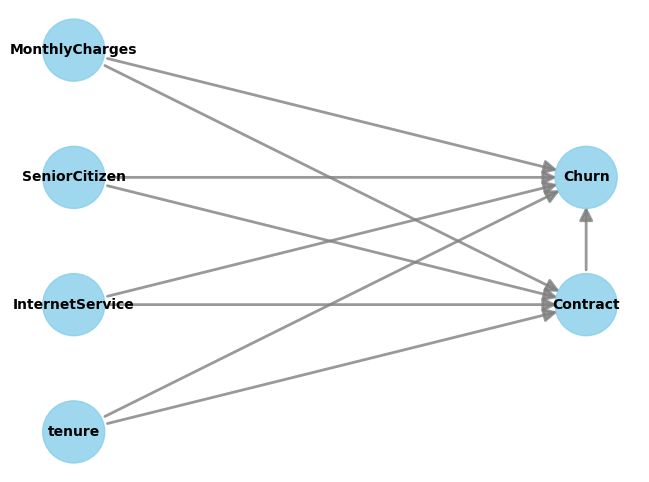

In [368]:
# ============================================================
# DoWhy — Causal Graph & Effect Estimation
# ============================================================

causal_df = df[[
    "Churn",
    "Contract",
    "MonthlyCharges",
    "tenure",
    "InternetService",
    "SeniorCitizen"
]]

model = CausalModel(
    data=causal_df,
    treatment="Contract",
    outcome="Churn",
    common_causes=["MonthlyCharges", "tenure", "InternetService", "SeniorCitizen"]
)

model.view_model()
plt.show()

